In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Activation,MaxPooling2D,Dropout
import seaborn as sns
import visualkeras
import keras_tuner 
import keras_tuner as kt
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Loading DataSet

In [40]:
image_dir = Path(r'D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafProject\Leaf Project Contents\FINALDATASET')

In [41]:
filepaths = list(image_dir.glob(r'**\*.jpg'))

In [42]:
len(filepaths)

2146

In [43]:
labels = []
for i in range(len(filepaths)):
    
    # list.append(i)

    label=str(filepaths[i]).split('\\')[-2].split(".",1)[0]
    labels.append(label)
    
    
    # labels = pd.Series(labels, name='Labels')

In [44]:
labels[80:85]

['Amrud', 'Amrud', 'Amrud', 'Amrud', 'Amrud']

# Creating Data Frame

In [45]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
df = pd.concat([filepaths, labels], axis=1)
df = df.sample(frac=1).reset_index(drop = True)

In [46]:
image_df=df
image_df.head()

,Filepath,Label
0,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Neem
1,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Chandni
2,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Arhul
3,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Jackfruit
4,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Arhul


In [47]:
image_df.dtypes

Filepath    object
Label       object
dtype: object

In [48]:
image_df.shape

(2146, 2)

In [49]:
image_df.describe()

,Filepath,Label
count,2146,2146
unique,2146,32
top,D:\CDAC SOFTWARE\abhinandan\CDAC\Project\LeafP...,Giloy
freq,1,192


# Details Of DataSet

In [50]:
print('-- Training set --\n')
print(f'Number of pictures: {image_df.shape[0]}\n')
print(f'Number of different labels: {len(image_df.Label.unique())}\n')
print(f'Labels: {image_df.Label.unique().tolist()}')

-- Training set --

Number of pictures: 2146

Number of different labels: 32

Labels: ['Neem', 'Chandni', 'Arhul', 'Jackfruit', 'Peepal', 'Tindora', 'Nimbu', 'Karanda', 'Drumstick', 'Mogra', 'Curry', 'Giloy', 'Chandan', 'Karanja', 'Amrud', 'Rasna', 'Anaar', 'Harive-Dantu', 'Pudina', 'Jamun', 'Jamaica Cherry', 'Paan', 'Ghrit Kumari', 'Malabar spinach', 'Rose Apple', 'Aam', 'Oleander', 'Phagoora', 'Parijata', 'Sarso', 'Tulsi', 'Mithi']


# Preprocessing Data

## Augumentation

In [51]:
train_DataGenerator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2)

test_DataGenerator = ImageDataGenerator(
    rescale=1/255)

In [52]:
train_df, test_df = train_test_split(image_df, 
                                     test_size=0.2, 
                                     shuffle=True, 
                                     random_state=1)

In [53]:
train_images = train_DataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    directory = image_dir,
    target_size=(128, 128),
    class_mode="categorical",
    seed=42,
    subset='training'
)

Found 1373 validated image filenames belonging to 32 classes.


In [54]:
val_images = train_DataGenerator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    directory = image_dir,
    target_size=(128, 128),
    class_mode="categorical",
    seed=42,
    subset='validation'
)

Found 343 validated image filenames belonging to 32 classes.


In [55]:
test_images = test_DataGenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    directory = image_dir,
    target_size=(128, 128),
    class_mode="categorical"
)

Found 430 validated image filenames belonging to 32 classes.


In [56]:
test_images.image_shape, train_images.image_shape

((128, 128, 3), (128, 128, 3))

# Hyperparameter Tunning Of Model

In [57]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('n_layers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))

    model.add(Flatten()) 
    model.add(Dense(32))
    model.add(Activation("softmax"))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [58]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,# how many variations on model?
    overwrite=True,
    executions_per_trial=2,  # how many trials per variation? (same model could perform differently)
    )

In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}


In [23]:
tuner.search(x=train_images,
             epochs=10,
             batch_size=64,
             validation_data=(test_images))

Trial 2 Complete [00h 35m 18s]
val_accuracy: 0.7825581431388855

Best val_accuracy So Far: 0.7825581431388855
Total elapsed time: 01h 18m 38s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
input_units: 224
n_layers: 1
conv_0_units: 192
conv_1_units: 96
conv_2_units: 96
Score: 0.7825581431388855
Trial summary
Hyperparameters:
input_units: 192
n_layers: 3
conv_0_units: 224
conv_1_units: 32
conv_2_units: 32
Score: 0.39767443388700485


In [25]:
tuner.get_best_hyperparameters()[0].values

{'input_units': 224,
 'n_layers': 1,
 'conv_0_units': 192,
 'conv_1_units': 96,
 'conv_2_units': 96}

In [35]:
from keras_tuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

build_model(kt.HyperParameters())

In [37]:
models = tuner.get_best_models()
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 128,128,3))
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 224)     6272      
                                                                 
 activation (Activation)     (None, 126, 126, 224)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 224)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 192)       387264    
                                                                 
 activation_1 (Activation)   (None, 61, 61, 192)       0         
                                                                 
 flatten (Flatten)           (None, 714432)            0         
                                                        

# Convolution Neural Network (CNN)

In [59]:
# Create a Sqequntial model object
model = Sequential()

# Add first Conv and pool layers
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 activation = "relu", 
                 input_shape = (128, 128, 3),
                 name= "Input_Layer"))
model.add(MaxPool2D((2,2), name = "Pooling_1"))

# 2nd Conv and pool layers
model.add(Conv2D(filters = 32, 
                 kernel_size = (3,3), 
                 activation = "relu", 
                 name= "Conv_Layer"))
model.add(MaxPool2D((2,2), name = "Pooling_2"))
# 3rd Conv and pool layers
model.add(Conv2D(filters = 64, 
                kernel_size = (3,3), 
                activation = "relu", 
                name= "Conv_Layer3"))
model.add(MaxPool2D((2,2), name = "Pooling_3"))
#4th Conv and pool layers
model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 activation = "relu", 
                 name= "Conv_Layer4"))
model.add(MaxPool2D((2,2), name = "Pooling_4"))

# Flatten the conv layer
model.add(Flatten())

# Add FC layers
model.add(Dense(128, activation="relu", name="Dense_1")) # FC1
model.add(Dense(64, activation="relu", name="Dense_2")) # FC2
model.add(Dense(32, activation="softmax", name="Output_Layer")) # FC3 - Output FC layer

## Visualising The Model

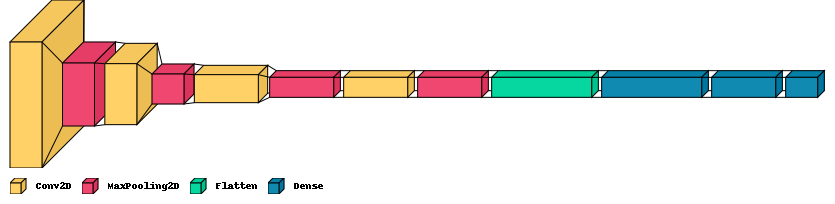

In [60]:
visualkeras.layered_view(model, scale_xy=1,scale_z=1,legend=True,max_z=100)

## Model Summary

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (Conv2D)        (None, 126, 126, 32)      896       
                                                                 
 Pooling_1 (MaxPooling2D)    (None, 63, 63, 32)        0         
                                                                 
 Conv_Layer (Conv2D)         (None, 61, 61, 32)        9248      
                                                                 
 Pooling_2 (MaxPooling2D)    (None, 30, 30, 32)        0         
                                                                 
 Conv_Layer3 (Conv2D)        (None, 28, 28, 64)        18496     
                                                                 
 Pooling_3 (MaxPooling2D)    (None, 14, 14, 64)        0         
                                                                 
 Conv_Layer4 (Conv2D)        (None, 12, 12, 64)       

# Compile / Optimizing The Model

In [62]:
# adam = tf.keras.optimizers.Adam( learning_rate=0.001)

In [63]:
model.compile(
    optimizer="adam", # with RMS accuracy is less around 20 percent with 2 epoc
    loss="categorical_crossentropy", 
    metrics="accuracy"
)

# Building/Train a model 

In [ ]:
# Build/Train the model using CNN
leaf_model = model.fit(
    train_images,
    epochs = 30,
    validation_data=val_images
)

Epoch 1/30
43/43 [==============================] - 104s 2s/step - loss: 3.3455 - accuracy: 0.1085 - val_loss: 2.9983 - val_accuracy: 0.2595
Epoch 2/30
43/43 [==============================] - 41s 961ms/step - loss: 2.2993 - accuracy: 0.3671 - val_loss: 2.0586 - val_accuracy: 0.4344
Epoch 3/30
43/43 [==============================] - 45s 1s/step - loss: 1.4041 - accuracy: 0.5732 - val_loss: 1.4499 - val_accuracy: 0.5714
Epoch 4/30
43/43 [==============================] - 42s 967ms/step - loss: 1.0532 - accuracy: 0.6744 - val_loss: 1.3683 - val_accuracy: 0.6414
Epoch 5/30
43/43 [==============================] - 46s 1s/step - loss: 0.9127 - accuracy: 0.7283 - val_loss: 1.1397 - val_accuracy: 0.6968
Epoch 6/30
43/43 [==============================] - 42s 983ms/step - loss: 0.6927 - accuracy: 0.7910 - val_loss: 0.9656 - val_accuracy: 0.7376
Epoch 7/30
43/43 [==============================] - 42s 969ms/step - loss: 0.5497 - accuracy: 0.8245 - val_loss: 1.0237 - val_accuracy: 0.7143
Epoch 8

 * 30 epoches are required to get the maximum accuracy *

## Training Model Vizualisation

In [ ]:
plt.plot(leaf_model.history['accuracy'], label="train_accuracy")
plt.plot(leaf_model.history['val_accuracy'], label="val_accuracy")

plt.plot(leaf_model.history['loss'], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Saving The Model

In [ ]:
model.save("./models/leaf_model4.h5", save_format='h5')

# Evaluating/Testing The Model

In [ ]:
model.evaluate(test_images)

*  The train accuracy is 100 percent and test accuracy is 83.37 with 30 epoches*

In [ ]:
(test_images.class_indices)

# Checking The Predictions 

In [ ]:
prediction_pobabilities = model.predict(test_images)

In [ ]:
prediction_pobabilities

In [ ]:
test_predictions = [np.argmax(prob) for prob in prediction_pobabilities]

In [ ]:
type(test_predictions)

In [ ]:
cm = confusion_matrix(test_images.labels, test_predictions)
cm

# Classification Report

In [ ]:
print(classification_report(test_images.labels, test_predictions))